# Data visualization

## Author: M. Ravasi

This notebook showcases the different routines present in ``devitofwi.visual`` to display data for QC purposes.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy.optimize import minimize
from pylops.basicoperators import Identity

from devito import configuration
from tqdm.notebook import tqdm

from examples.seismic import AcquisitionGeometry, Model, Receiver
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

from devitofwi.devito.utils import clear_devito_cache
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.visual.data import display_multiple_gathers, display_sidebyside

configuration['log-level'] = 'ERROR'

In [2]:
clear_devito_cache()

## Parameters 

In [3]:
# Model and aquisition parameters
par = {'nx':601,   'dx':15,    'ox':0,
       'nz':221,   'dz':15,    'oz':0,
       'ns':20,    'ds':300,   'os':1000,  'sz':0,
       'nr':300,   'dr':30,    'or':0,     'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':15,
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

## Acquisition set-up

In [4]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1] * 1e3 # in ms

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

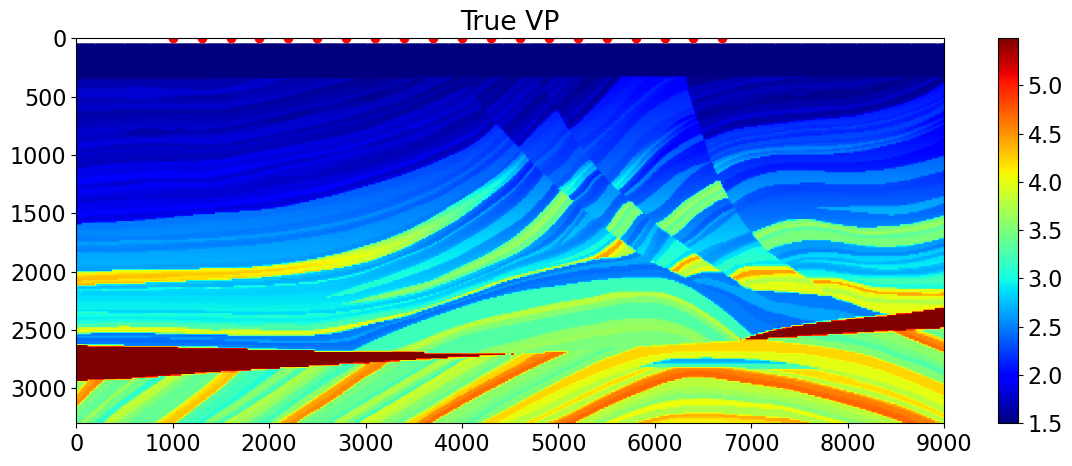

In [5]:
# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

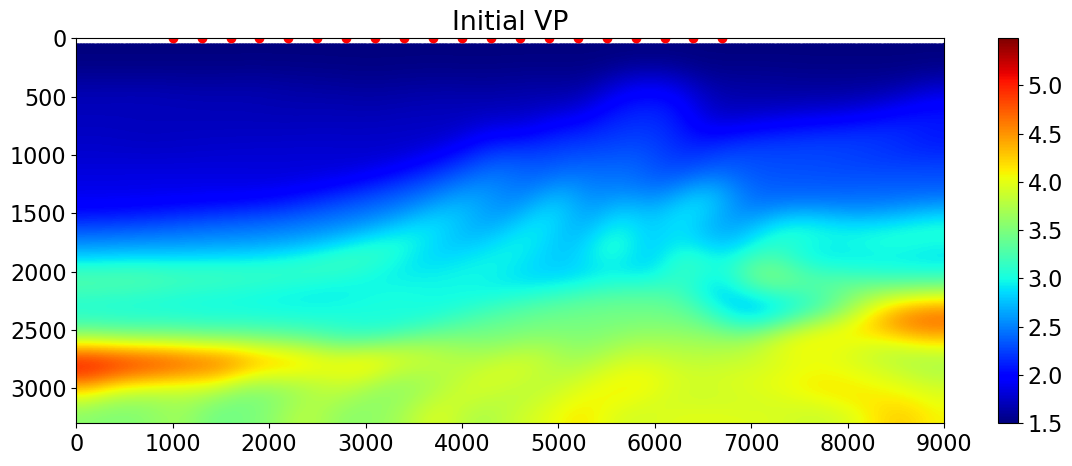

In [6]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [7]:
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,
                      vp=vp_true * 1e3, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl)

In [8]:
# Model data
dobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

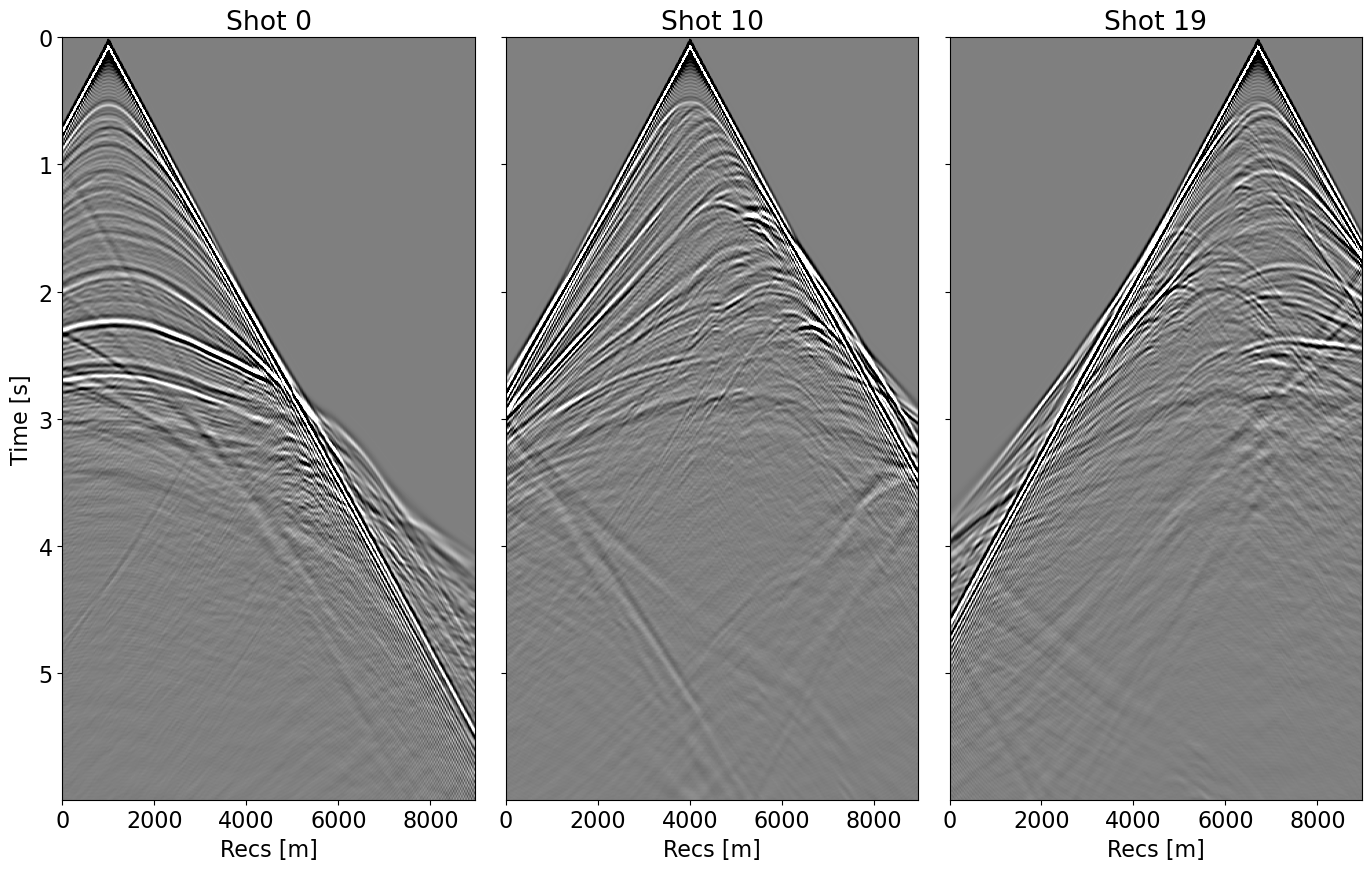

In [19]:
# Plot shot gathers
display_multiple_gathers(dobs, ishots=(0, par['ns']//2, par['ns']-1), 
                         recs=x_r[:, 0], t=amod.geometry.time_axis.time_values * 1e-3, 
                         figsize=(14, 9), vclip=1e-2);

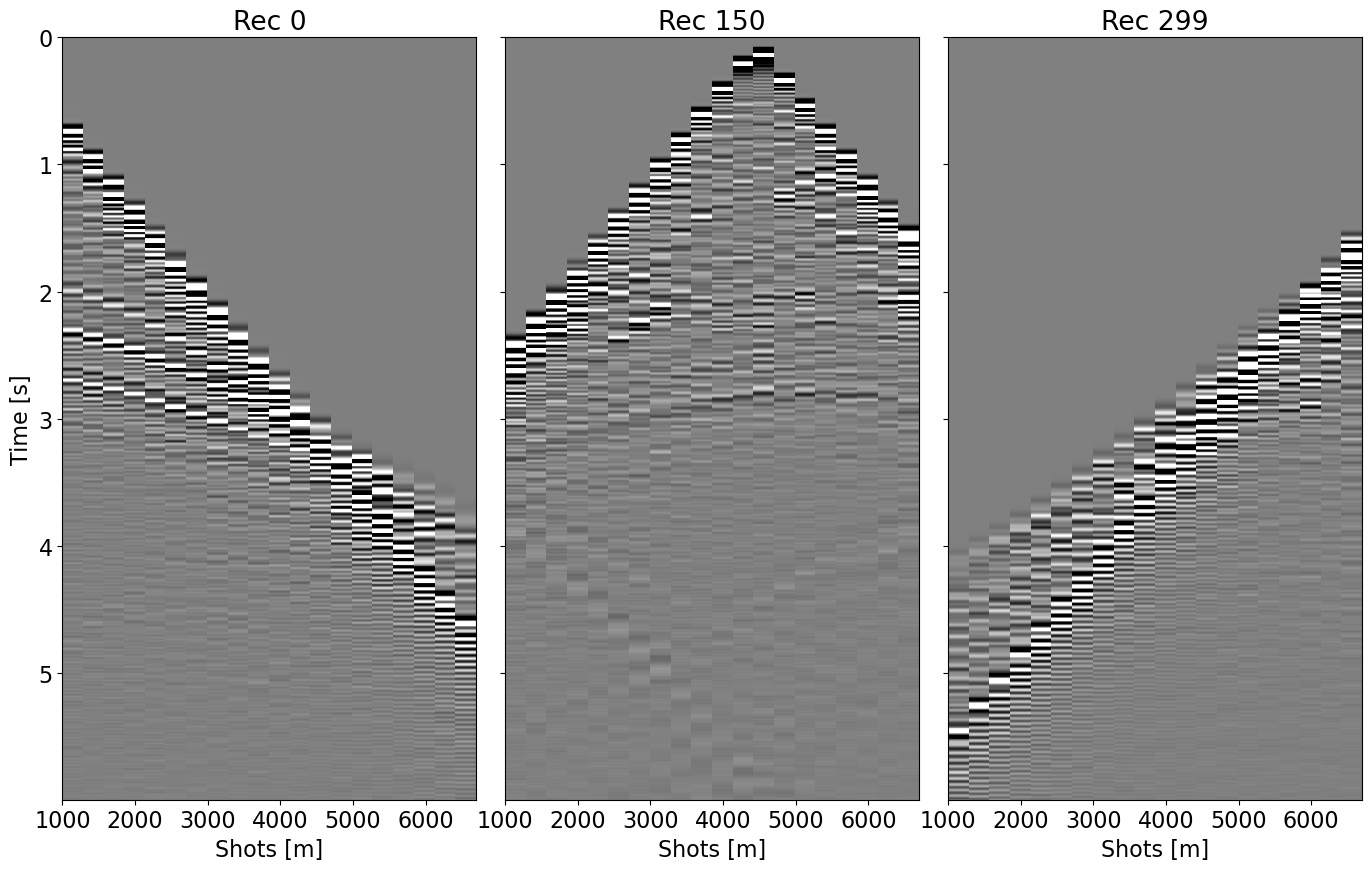

In [18]:
# Plot receiver gathers
display_multiple_gathers(dobs, irecs=(0, par['nr']//2, par['nr']-1), 
                         srcs=x_s[:, 0], t=amod.geometry.time_axis.time_values * 1e-3, 
                         figsize=(14, 9), vclip=1e-2, interpolation='none');

## Data modelling with initial velocity model

In [10]:
amodinit = AcousticWave2D(shape, origin, spacing, 
                        x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                        0., tmax,
                        vp=vp_init * 1e3, 
                        src_type="Ricker", f0=par['freq'],
                        space_order=space_order, nbl=nbl)

In [11]:
# Model initial data
dinit = amodinit.mod_allshots(amod.geometry.dt)

  0%|          | 0/20 [00:00<?, ?it/s]

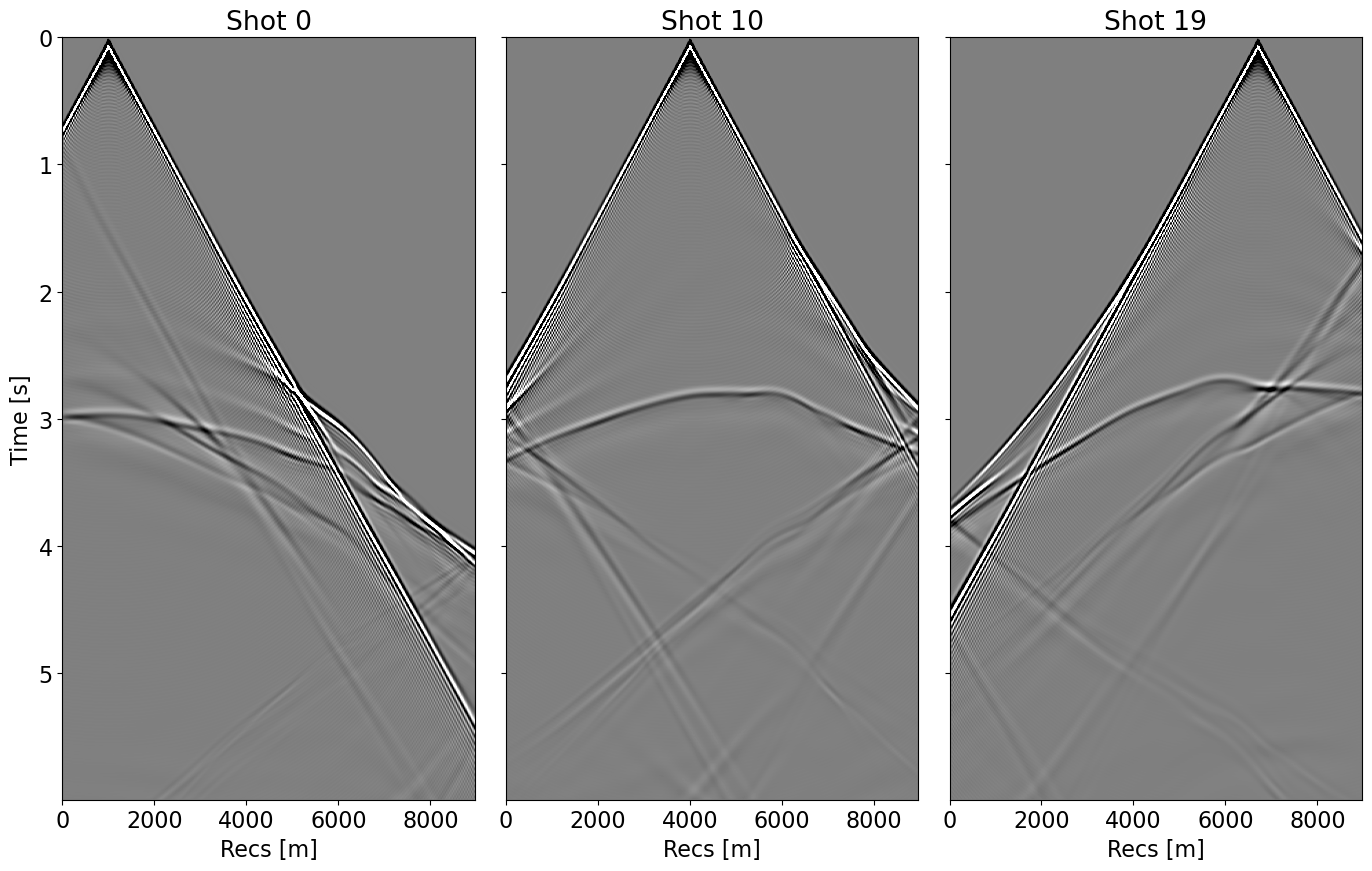

In [12]:
# Plot initial shot gathers
display_multiple_gathers(dinit, ishots=(0, par['ns']//2, par['ns']-1), 
                         recs=x_r[:, 0], t=amod.geometry.time_axis.time_values * 1e-3, 
                         vclip=1e-2, figsize=(14, 9));

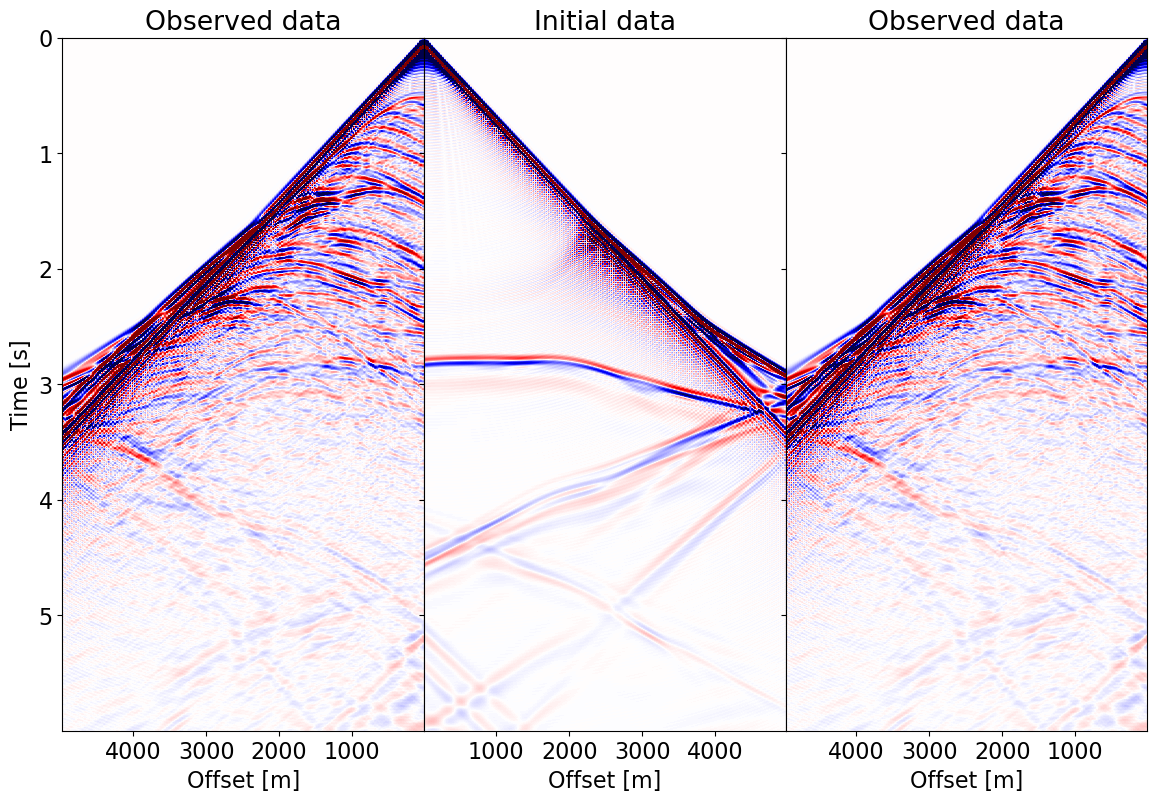

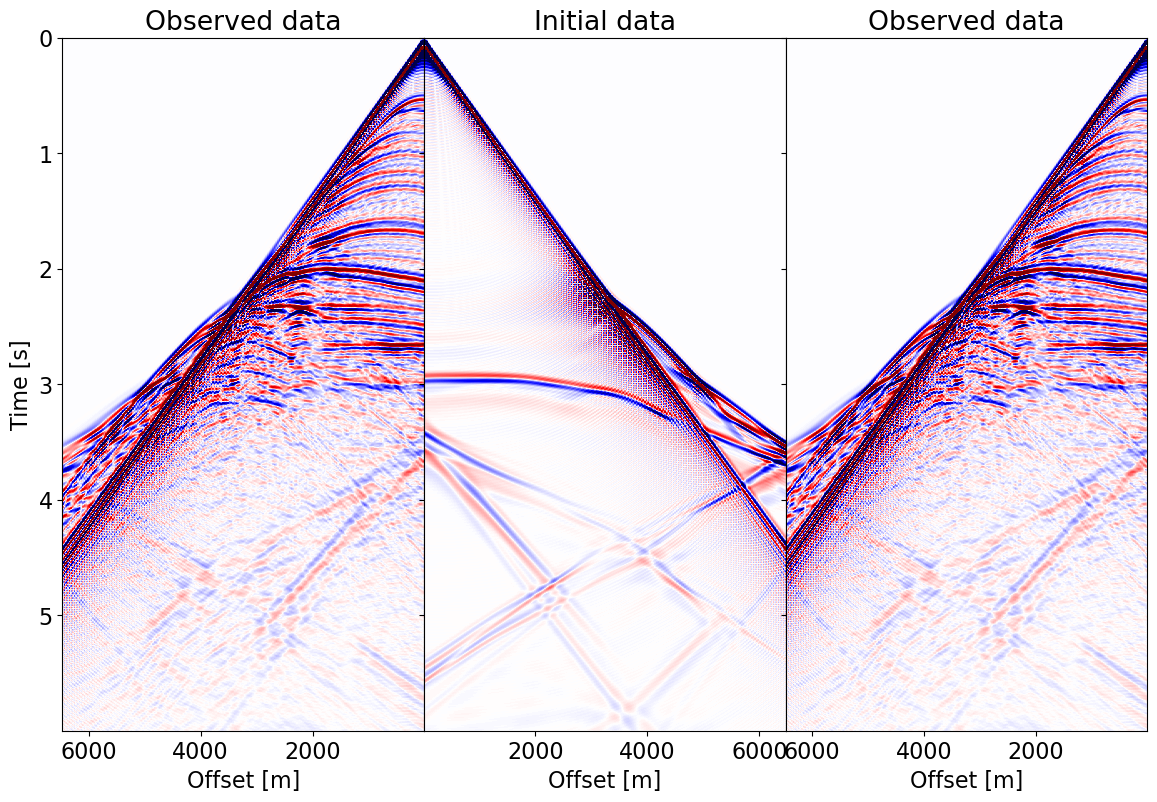

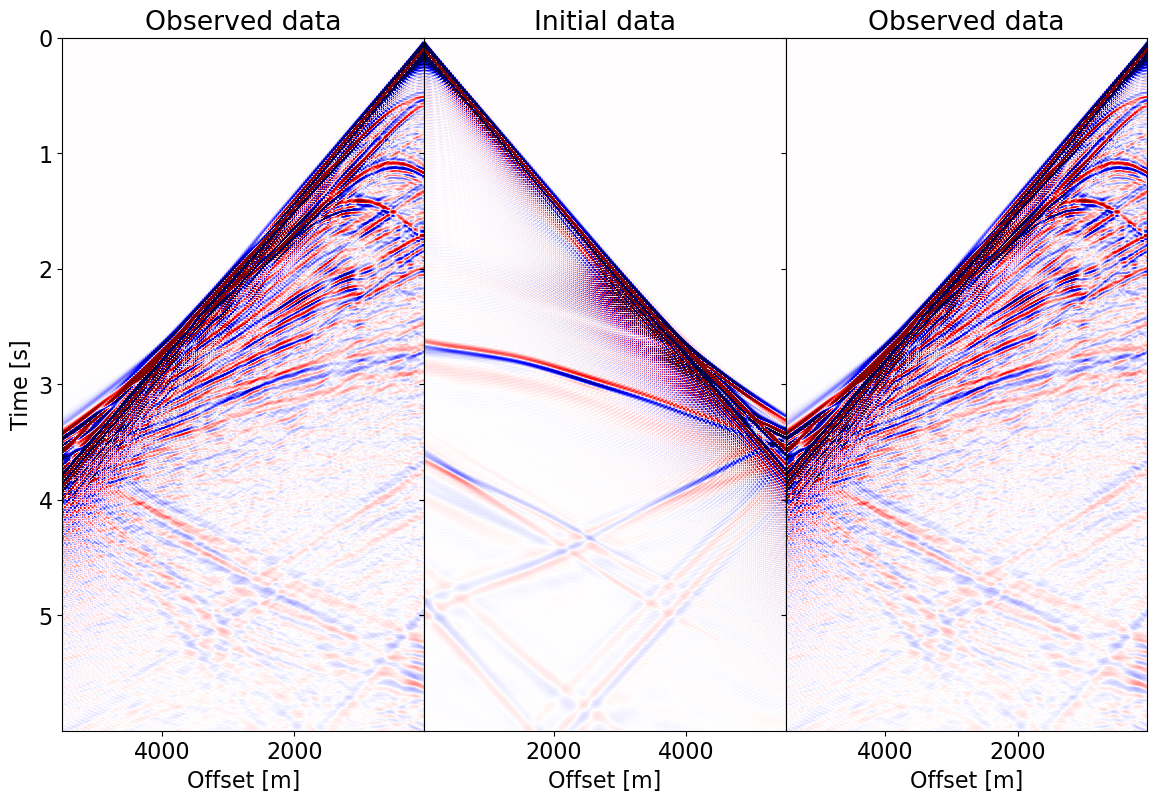

In [13]:
# Plot observed vs initial shot gathers

display_sidebyside(dobs, dinit, par['ns']//2, x_s[:, 0], x_r[:, 0], 
                   t=amod.geometry.time_axis.time_values * 1e-3, 
                   figsize=(14, 9), vclip=1e-2, cmap='seismic', 
                   titles=('Observed data', 'Initial data'));

display_sidebyside(dobs, dinit, 5, x_s[:, 0], x_r[:, 0], 
                   t=amod.geometry.time_axis.time_values * 1e-3, 
                   figsize=(14, 9), vclip=1e-2, cmap='seismic', 
                   titles=('Observed data', 'Initial data'));

display_sidebyside(dobs, dinit, -5, x_s[:, 0], x_r[:, 0], 
                   t=amod.geometry.time_axis.time_values * 1e-3, 
                   figsize=(14, 9), vclip=1e-2, cmap='seismic', 
                   titles=('Observed data', 'Initial data'));